In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

### Setup device and memory

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True 

## Define the training dataset structure

This `MultiLabelDualDataset` class takes a raw CSV file and transforms it into a multi-dimensional, phonetic-aware format that a Convolutional Neural Network (CNN) can actually see.

#### 1. The Multi-Label Strategy (Grouping)

* **`self.grouped`**: This code uses `df.groupby('full_text')` to collapse all annotation labels for the same instance into a single entry.
* **`label_vec`**: Instead of a single number, it creates a hot-bit vector (e.g., `[1, 0, 1, 1...]`). This tells the model: "For this one sentence, Alliteration, Rhyme, and Mesodiplosis are ALL true."

#### 2. `create_text_matrix` (The Visual Stream)

This creates a 3-channel text map ($3 \times 64 \times 64$).

* **Channel 0 (Identity)**: If word $i$ is exactly the same as word $j$, it marks a 1.0. This helps the model find **Mesodiplosis** or **Ploke**.
* **Channel 1 (First Letter)**: If words share a starting letter, it marks a 0.5. This is a hint for **Alliteration**.
* **Channel 2 (Punctuation)**: It flags commas and semicolons, helping the model understand where clauses start and end.

#### 3. `create_phone_matrix` (The Phonetic Stream)

This creates a 2-channel sound map ($2 \times 64 \times 64$).

* **Channel 0 (Sound Identity)**: Marks when words sound identical in the IPA (International Phonetic Alphabet).
* **Channel 1 (Suffix Match)**: Marks when the last two characters of the phonetic string match. This is useful for identifying **Rhyme** and **Assonance** that the text stream might miss.

In [3]:
class MultiLabelDualDataset(Dataset):
    def __init__(self, df, max_len=64):
        for col in ['full_text', 'full_text_phonetic', 'highlights', 'highlights_phonetic']:
            df[col] = df[col].fillna("")

        # Get all unique figures
        self.classes = sorted(df['figure_name'].unique())
        self.num_classes = len(self.classes)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Collect all labels for the same text instance
        self.grouped = df.groupby('full_text').agg({
            'full_text_phonetic': 'first',
            'figure_name': lambda x: list(set(x)),
            'highlights': lambda x: '; '.join(x.astype(str)),
            'highlights_phonetic': lambda x: '; '.join(x.astype(str))
        }).reset_index()

        self.max_len = max_len
        self.matrices_text = []
        self.matrices_phone = []
        self.multi_labels = []

        print(f"Generating Multi-Label Matrices for {len(self.grouped)} unique texts...")
        for _, row in self.grouped.iterrows():
            self.matrices_text.append(self.create_text_matrix(row['full_text']))
            self.matrices_phone.append(self.create_phone_matrix(row['full_text_phonetic']))
            
            # Create Binary Label Vector [0, 1, 0, 0, 1...]
            label_vec = np.zeros(self.num_classes, dtype=np.float32)
            for fig in row['figure_name']:
                label_vec[self.class_to_idx[fig]] = 1.0
            self.multi_labels.append(label_vec)

    def create_text_matrix(self, text):
        raw_words = str(text).lower().split()
        clean_words = [w.strip('.,!?;:"()') for w in raw_words]
        matrix = np.zeros((3, self.max_len, self.max_len), dtype=np.float32)
        for i in range(min(len(clean_words), self.max_len)):
            for j in range(min(len(clean_words), self.max_len)):
                if i == j: continue
                if clean_words[i] == clean_words[j] and len(clean_words[i]) > 0:
                    matrix[0, i, j] = 1.0
                if clean_words[i][:1] == clean_words[j][:1]: matrix[1, i, j] += 0.5
                if any(p in raw_words[i] for p in [',', ';', ':']): matrix[2, i, j] = 1.0
        return matrix

    def create_phone_matrix(self, phone_text):
        phone_words = str(phone_text).lower().split()
        matrix = np.zeros((2, self.max_len, self.max_len), dtype=np.float32)
        for i in range(min(len(phone_words), self.max_len)):
            for j in range(min(len(phone_words), self.max_len)):
                if i == j: continue
                if phone_words[i] == phone_words[j]: matrix[0, i, j] = 1.0
                if phone_words[i][-2:] == phone_words[j][-2:]: matrix[1, i, j] = 1.0
        return matrix

    def __len__(self): return len(self.grouped)
    def __getitem__(self, idx):
        return (torch.tensor(self.matrices_text[idx]), 
                torch.tensor(self.matrices_phone[idx]), 
                torch.tensor(self.multi_labels[idx]))

## Model structure

This StreamEncoder class is the pattern recognizer of the architecture. It uses Convolutional Neural Networks (CNNs) to scan for the shapes of the rhetorical figure matrices.

* **`nn.Conv2d` (Convolutional Layers)**: These act as filters that slide across the matrices. The first layer identifies simple relationships like adjacent word repetitions, while the second layer identifies more complex structures like Anadiplosis or Antimetabole.

* **`nn.BatchNorm2d` (Batch Normalization)**: This stabilizes the training process. It ensures that the activations don't get too large or too small, which helps the model learn faster and prevents the loss from rising too much.

* **`nn.ReLU` (Activation Function)**: This introduces non-linearity. It allows the model to ignore weak signals (negative values) and focus only on strong patterns that match rhetorical figures.

* **`nn.MaxPool2d` and `nn.AdaptiveAvgPool2d` (Pooling Layers)**: These layers shrink the data while keeping the most important information. `MaxPool` reduces the spatial size by taking the strongest signal in a $2 \times 2$ window. `AdaptiveAvgPool` forces the final output into a consistent $4 \times 4$ size, regardless of the input sentence length.

In [4]:
class StreamEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
    def forward(self, x): return self.conv(x)

This `DualStreamCNN` class is where the visual and phonetic data finally meet to make a decision. Instead of mixing the text and sounds at the beginning, the model lets each encoder finish their individual analysis before combining their findings.

* **Dual Encoders (`text_encoder` & `phone_encoder`)**:
The model creates two separate specialized branches. The `text_encoder` processes the $3$-channel word-relationship matrix, while the `phone_encoder` processes the $2$-channel phonetic-relationship matrix. This allows the model to listen and read at the same time.

* **`torch.cat` (The Fusion Point)**:
This is the critical step in the `forward` method. It takes the feature maps from both encoders and concatenates them into one long vector. If the text encoder sees a word repetition and the phone encoder hears a rhyme, this combined vector now contains both pieces of evidence.

* **`nn.Flatten`**:
CNNs output 3D shapes (height, width, depth). The classifier needs a 1D list of numbers. Flattening converts the $4 \times 4 \times 64$ feature maps from both streams into a single flat line of data.

* **`nn.Dropout(0.5)`**:
This is a regularization technique. During training, it randomly disables 50% of the neurons. This forces the model to not rely too heavily on any single pattern, making it more robust when it sees new sentences.

* **`nn.Linear(512, num_classes)`**:
The final layer. It maps the 512 internal features the model discovered down to the specific rhetorical figures (e.g., *Alliteration, Rhyme, Mesodiplosis*).

In [5]:
class DualStreamCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.text_encoder = StreamEncoder(3)
        self.phone_encoder = StreamEncoder(2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((64 * 4 * 4) * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, txt, phn):
        t_feat = self.text_encoder(txt)
        p_feat = self.phone_encoder(phn)
        combined = torch.cat((t_feat, p_feat), dim=1)
        return self.classifier(combined)

## Training and evaluation

* By using Multi-Label training, we stop punishing the model for finding more than one figure. It can now say yes to all the figures present in the sentence.
**BinaryCrossEntropy (BCE) with Logits** treats each of the 12 rhetorical figures as an independent Yes/No question.

* Rare figures (like Antimetabole) might never reach 0.5 confidence, while common ones (like Ploke) might always be above it. The loop `for thresh in np.linspace(0.05, 0.5, 20)` finds a unique sweet spot for every single figure. If the model is consistently 20% sure about Assonance, your code lowers the bar to 0.20 to make sure it gets caught.

* A co-occurrence matrix tracks how often two figures appear together. In simple terms, it answers the question *"Of all the times the model identified Figure A, what percentage of those cases did it also find Figure B?"*

In [ ]:
def train_and_evaluate(csv_path):
    df = pd.read_csv(csv_path)
    dataset = MultiLabelDualDataset(df)
    
    indices = np.arange(len(dataset))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=32, shuffle=True)
    test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=32, shuffle=False)

    model = DualStreamCNN(dataset.num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    print("Starting Multi-Label training...")
    for epoch in range(100):
        model.train()
        total_loss = 0
        for txt, phn, labs in train_loader:
            txt, phn, labs = txt.to(device), phn.to(device), labs.to(device)
            optimizer.zero_grad()
            output = model(txt, phn)
            loss = criterion(output, labs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

    print("Starting Multi-Label evaluation...")
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for txt, phn, labs in test_loader:
            txt, phn, labs = txt.to(device), phn.to(device), labs.to(device)
            # Get raw scores
            output = torch.sigmoid(model(txt, phn))
            all_outputs.extend(output.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)

    # Find best thresholds
    best_thresholds = []
    final_preds = np.zeros_like(all_outputs)

    for i in range(dataset.num_classes):
        best_f1 = 0
        best_thresh = 0.5
        # Test thresholds from 0.05 to 0.50
        for thresh in np.linspace(0.05, 0.5, 20):
            preds = (all_outputs[:, i] > thresh).astype(float)
            f1 = f1_score(all_labels[:, i], preds)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        
        best_thresholds.append(best_thresh)
        final_preds[:, i] = (all_outputs[:, i] > best_thresh).astype(float)
        print(f"Figure: {dataset.classes[i]:<15} | Best Threshold: {best_thresh:.2f}")

    print("\nOptimized Multi-Label Classification Report:")
    print(classification_report(all_labels, final_preds, target_names=dataset.classes))

    co_matrix = np.dot(final_preds.T, final_preds)

    # Normalize by the diagonal
    diag = np.diagonal(co_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        co_matrix_norm = co_matrix / diag[:, None]
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(co_matrix_norm, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=dataset.classes, 
                yticklabels=dataset.classes)
    
    plt.title('Rhetorical Figure Co-occurrence (Normalized)\n"When I see Row, how often do I also see Column?"')
    plt.xlabel('Associated Figure')
    plt.ylabel('Detected Figure')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./training/rhetoric_co_occurrence.png')
    plt.show()

    save_data = {
        'model_state_dict': model.state_dict(),
        'classes': dataset.classes,
        'thresholds': best_thresholds
    }
    torch.save(save_data, './models/rhetoric_multilabel_model.pth')
    print("Model saved successfully at './models/rhetoric_multilabel_model.pth'")

    del model
    gc.collect()
    torch.cuda.empty_cache()

Generating Multi-Label Matrices for 3111 unique texts...
Starting Multi-Label training...
Epoch 10 | Loss: 0.4278
Epoch 20 | Loss: 0.4075
Epoch 30 | Loss: 0.3938
Epoch 40 | Loss: 0.3757
Epoch 50 | Loss: 0.3549
Epoch 60 | Loss: 0.3358
Epoch 70 | Loss: 0.3110
Epoch 80 | Loss: 0.2892
Epoch 90 | Loss: 0.2704
Epoch 100 | Loss: 0.2475
Figure: alliteration    | Best Threshold: 0.07
Figure: anadiplosis     | Best Threshold: 0.07
Figure: antimetabole    | Best Threshold: 0.22
Figure: assonance       | Best Threshold: 0.05
Figure: consonance      | Best Threshold: 0.05
Figure: epanalepsis     | Best Threshold: 0.14
Figure: epanaphora      | Best Threshold: 0.19
Figure: epiphora        | Best Threshold: 0.10
Figure: epizeuxis       | Best Threshold: 0.07
Figure: mesodiplosis    | Best Threshold: 0.22
Figure: ploke           | Best Threshold: 0.12
Figure: rhyme           | Best Threshold: 0.05

Optimized Multi-Label Classification Report:
              precision    recall  f1-score   support

alli

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


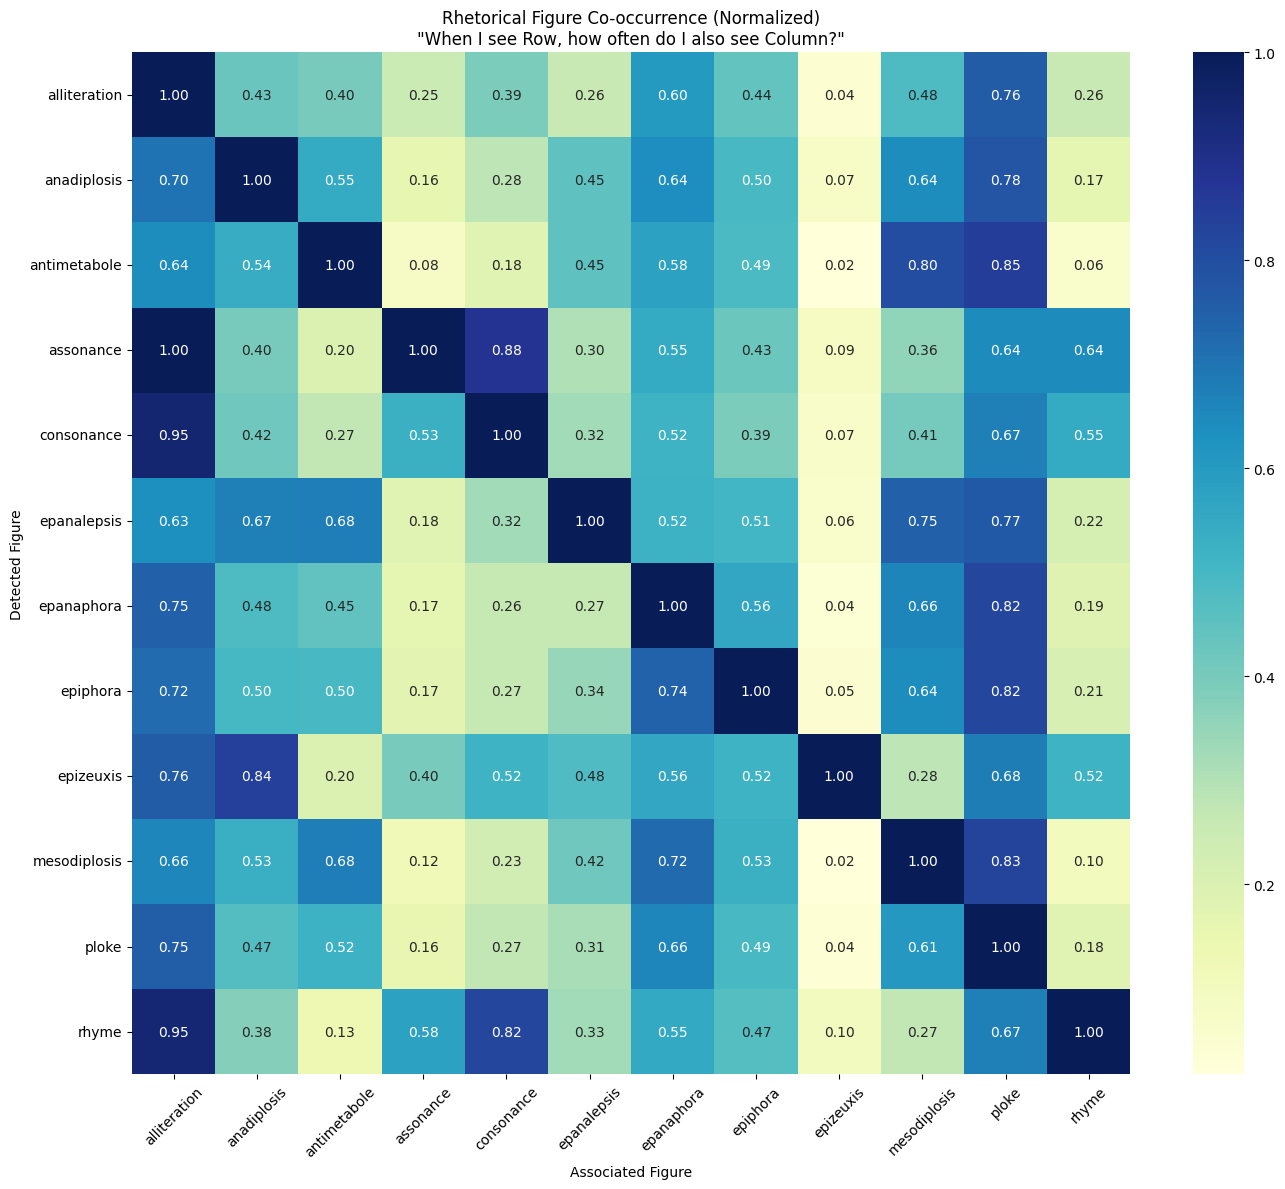

Model saved successfully as 'rhetoric_multilabel_model.pth'


In [7]:
train_and_evaluate("./training/gofigure_phonetized.csv")

## Model Evaluation

In [6]:
def create_text_matrix(text, max_len=64):
    raw_words = str(text).lower().split()
    clean_words = [w.strip('.,!?;:"()') for w in raw_words]
    matrix = np.zeros((3, max_len, max_len), dtype=np.float32)

    for i in range(min(len(clean_words), max_len)):
        for j in range(min(len(clean_words), max_len)):
            if i == j: continue
            if clean_words[i] == clean_words[j] and len(clean_words[i]) > 0:
                matrix[0, i, j] = 1.0
            if clean_words[i][:1] == clean_words[j][:1]: matrix[1, i, j] += 0.5
            if any(p in raw_words[i] for p in [',', ';', ':']): matrix[2, i, j] = 1.0
    return matrix

def create_phone_matrix(phone_text, max_len=64):
    phone_words = str(phone_text).lower().split()
    matrix = np.zeros((2, max_len, max_len), dtype=np.float32)

    for i in range(min(len(phone_words), max_len)):
        for j in range(min(len(phone_words), max_len)):
            if i == j: continue
            if phone_words[i] == phone_words[j]:
                matrix[0, i, j] = 1.0
            if phone_words[i][-2:] == phone_words[j][-2:]:
                matrix[1, i, j] = 1.0
    return matrix

In [7]:
def identify_highlights(text, phonetic_text, model_path='./models/rhetoric_multilabel_model.pth'):
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model = DualStreamCNN(num_classes=len(checkpoint['classes'])).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get matrices and original word list
    words = text.lower().split()
    txt_mat = create_text_matrix(text) 
    phn_mat = create_phone_matrix(phonetic_text)

    txt_tensor = torch.tensor(txt_mat).unsqueeze(0).to(device)
    phn_tensor = torch.tensor(phn_mat).unsqueeze(0).to(device)

    with torch.no_grad():
        output = torch.sigmoid(model(txt_tensor, phn_tensor)).cpu().numpy()[0]

    print(f"\n--- Analysis for: \"{text}\" ---")
    
    for i, score in enumerate(output):
        if score > checkpoint['thresholds'][i]:
            fig_name = checkpoint['classes'][i].lower()
            detected_words = set()

            # For structural figures (Mesodiplosis, Anadiplosis, etc.)
            if fig_name in ['mesodiplosis', 'anadiplosis', 'antimetabole', 'epanalepsis', 'ploke']:
                # Channel 0 (Word Identity)
                coords = np.vstack([np.argwhere(txt_mat[0] > 0)])
                for r, c in coords:
                    if r < len(words): detected_words.add(words[r])
                    if c < len(words): detected_words.add(words[c])

            # For phonetic figures (Alliteration, Rhyme, Assonance)
            elif fig_name in ['alliteration', 'rhyme', 'assonance', 'consonance']:
                # Channel 0 (Phonetic Identity) and Channel 1 (Phonetic Ending/Rhyme)
                coords = np.vstack([np.argwhere(phn_mat[0] > 0), np.argwhere(phn_mat[1] > 0)])
                for r, c in coords:
                    if r < len(words): detected_words.add(words[r])
                    if c < len(words): detected_words.add(words[c])

            print(f"-> FIGURE: {fig_name.upper()} (Confidence: {score:.2f})")
            print(f"   HIGHLIGHTS: {', '.join(list(detected_words)) if detected_words else 'General Pattern'}")

identify_highlights("Ultrabooks are laptops after all, but not all laptops are ultrabooks. In essence, Ultrabooks are just a special type of laptop", "ʌ l t ɹ ə b ʊ k s <W> ɑːɹ <W> l æ p t ɑː p s <W> æ f t ɚ ɹ <W> ɔː l <W> b ʌ t <W> n ɑː t <W> ɔː l <W> l æ p t ɑː p s <W> ɑː ɹ <W> ʌ l t ɹ ə b ʊ k s <W> ɪ n <W> ɛ s ə n s <W> ʌ l t ɹ ə b ʊ k s <W> ɑːɹ <W> dʒ ʌ s t <W> ɐ <W> s p ɛ ʃ əl <W> t aɪ p <W> ʌ v <W> l æ p t ɑː p s")
identify_highlights("Old King Cole was a merry old soul And a merry old soul was he", "oʊ l d <W> k ɪ ŋ <W> k oʊ l <W> w ʌ z ɐ <W> m ɛ ɹ i <W> oʊ l d <W> s oʊ l <W> æ n d <W> ɐ <W> m ɛ ɹ i <W> oʊ l d <W> s oʊ l <W> w ʌ z <W> h iː")


--- Analysis for: "Ultrabooks are laptops after all, but not all laptops are ultrabooks. In essence, Ultrabooks are just a special type of laptop" ---
-> FIGURE: ANADIPLOSIS (Confidence: 0.20)
   HIGHLIGHTS: are, ultrabooks., laptops, all,, all, ultrabooks
-> FIGURE: ANTIMETABOLE (Confidence: 0.85)
   HIGHLIGHTS: are, ultrabooks., laptops, all,, all, ultrabooks
-> FIGURE: EPANALEPSIS (Confidence: 0.47)
   HIGHLIGHTS: are, ultrabooks., laptops, all,, all, ultrabooks
-> FIGURE: EPANAPHORA (Confidence: 0.54)
   HIGHLIGHTS: General Pattern
-> FIGURE: MESODIPLOSIS (Confidence: 0.78)
   HIGHLIGHTS: are, ultrabooks., laptops, all,, all, ultrabooks
-> FIGURE: PLOKE (Confidence: 0.46)
   HIGHLIGHTS: are, ultrabooks., laptops, all,, all, ultrabooks

--- Analysis for: "Old King Cole was a merry old soul And a merry old soul was he" ---
-> FIGURE: ALLITERATION (Confidence: 0.19)
   HIGHLIGHTS: he, king, and, soul, old, merry, was, a, cole
-> FIGURE: EPANAPHORA (Confidence: 0.76)
   HIGHLIGHTS: Ge

The model is able to accurately predict the figures found in the text, but is unable to pinpoint where they are